## Practica 1 - Computer Vision

# Importación de librerías

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gdown

# Importación de datos

In [2]:
# Crear el directorio de datos si no existe
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# URL de Google Drive en formato correcto para gdown
url = "https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE"
zip_filename = "practica_1_dataset.zip"
zip_path = os.path.join(data_dir, zip_filename)

# Descargar el archivo
if not os.path.exists(zip_path):
    gdown.download(url, zip_path, quiet=False)
else:
    print("Data zipfile already exists")

Downloading...
From (original): https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE
From (redirected): https://drive.google.com/uc?id=1iGBv-VT5mm1RiouD-U2qWcU3BYqp2OwE&confirm=t&uuid=0c70384d-9f15-4d58-a26a-4b9f16c5c4a3
To: /content/data/practica_1_dataset.zip
100%|██████████| 69.6M/69.6M [00:02<00:00, 27.9MB/s]


In [3]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

data_dir = "data"
zip_filename = "practica_1_dataset.zip"
zip_path = os.path.join(data_dir, zip_filename)
subfolders = ["test", "train", "valid"]
full_paths = [os.path.join(data_dir, folder) for folder in subfolders]

if not all(os.path.isdir(path) for path in full_paths):
    with ZipFile(zip_path, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if not file.startswith("__MACOSX"):
                    exe.submit(zf.extract, file, path=data_dir)
else:
    print("test, train and valid folders already exist")

# Exploración de archivos

## Previo a la organización de la clase principal. Solo csv.

══════════════════════════════════════════════════
ESTADÍSTICAS BÁSICAS
══════════════════════════════════════════════════
Total de anotaciones: 4817
Número de imágenes únicas: 637
Clases disponibles: ['starfish' 'shark' 'fish' 'puffin' 'stingray' 'penguin' 'jellyfish']

══════════════════════════════════════════════════
DISTRIBUCIÓN DE CLASES
══════════════════════════════════════════════════


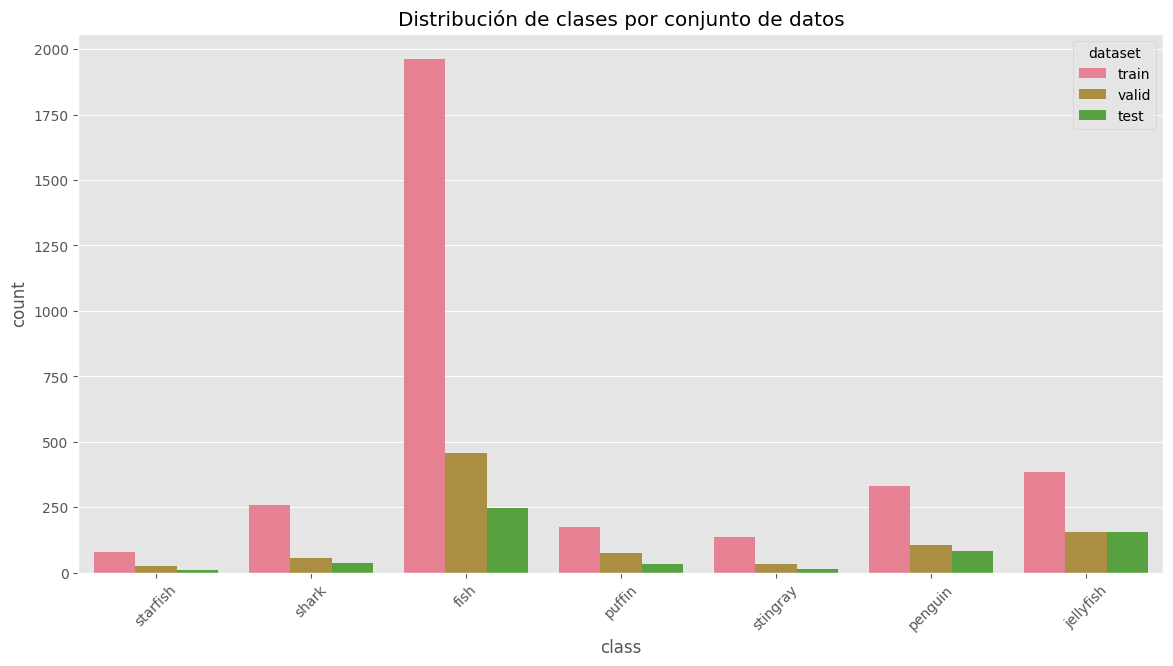


══════════════════════════════════════════════════
ANÁLISIS DE DIMENSIONES
══════════════════════════════════════════════════
Dimensiones más comunes:
   width  height  count
0    576    1024    519
1    768    1024   2963
2   1024     576    106
3   1024     768   1229

══════════════════════════════════════════════════
ANOTACIONES POR IMAGEN
══════════════════════════════════════════════════


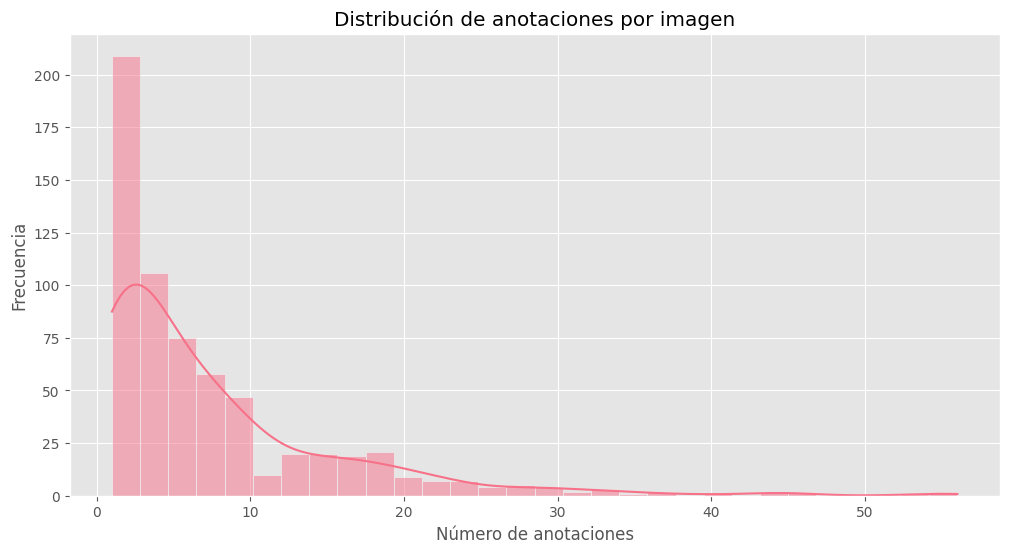


══════════════════════════════════════════════════
SUPERPOSICIÓN DE CLASES
══════════════════════════════════════════════════
Imágenes con múltiples clases: 198

Combinaciones:
('fish', 'shark'): 134 ocurrencias
('fish', 'stingray'): 80 ocurrencias
('shark', 'stingray'): 55 ocurrencias
('fish', 'starfish'): 14 ocurrencias
('shark', 'starfish'): 4 ocurrencias


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración de visualización
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Cargar datos
def load_annotations(path):
    df = pd.read_csv(path)
    df['dataset'] = os.path.basename(os.path.dirname(path))
    return df

# Cargar todos los datasets
combined_df = pd.concat([
    load_annotations("data/train/annotations.csv"),
    load_annotations("data/valid/annotations.csv"),
    load_annotations("data/test/annotations.csv")
])

# Análisis básico
print("═"*50)
print("ESTADÍSTICAS BÁSICAS")
print("═"*50)
print(f"Total de anotaciones: {combined_df.shape[0]}")
print(f"Número de imágenes únicas: {combined_df['filename'].nunique()}")
print(f"Clases disponibles: {combined_df['class'].unique()}")

# Distribución de clases
print("\n" + "═"*50)
print("DISTRIBUCIÓN DE CLASES")
print("═"*50)
class_dist = combined_df.groupby(['dataset', 'class']).size().unstack(fill_value=0)

# Gráfico de distribución de clases
plt.figure(figsize=(14, 7))
sns.countplot(data=combined_df, x='class', hue='dataset')
plt.title('Distribución de clases por conjunto de datos')
plt.xticks(rotation=45)
plt.show()

# Análisis de dimensiones de imágenes
print("\n" + "═"*50)
print("ANÁLISIS DE DIMENSIONES")
print("═"*50)
dimension_counts = combined_df.groupby(['width', 'height']).size().reset_index(name='count')
print("Dimensiones más comunes:")
print(dimension_counts.head())


# Análisis de anotaciones por imagen
print("\n" + "═"*50)
print("ANOTACIONES POR IMAGEN")
print("═"*50)
annotations_per_image = combined_df.groupby('filename').size()

plt.figure(figsize=(12, 6))
sns.histplot(annotations_per_image, bins=30, kde=True)
plt.title('Distribución de anotaciones por imagen')
plt.xlabel('Número de anotaciones')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de superposición de clases
print("\n" + "═"*50)
print("SUPERPOSICIÓN DE CLASES")
print("═"*50)
class_combinations = combined_df.groupby('filename')['class'].agg(lambda x: list(x.unique()))
print(f"Imágenes con múltiples clases: {sum(class_combinations.apply(len) > 1)}")

# Ejemplo de combinaciones comunes
from itertools import combinations
from collections import Counter

all_combinations = []
for classes in class_combinations:
    if len(classes) > 1:
        all_combinations.extend(combinations(sorted(classes), 2))

common_pairs = Counter(all_combinations).most_common(5)
print("\nCombinaciones:")
for pair, count in common_pairs:
    print(f"{pair}: {count} ocurrencias")


**Características del Dataset**

- El dataset contiene 637 imágenes únicas pero 4817 anotaciones totales, lo que indica una alta densidad de objetos por imagen. Esto habrá que tenerlo en cuenta a la hora de realizar las reetiquetar las imágenes

- Hay 7 clases marinas (starfish, shark, fish, puffin, stingray, penguin, jellyfish) que deben ser reconocidas por el modelo.

- Otro dato importante son las combinaciones de clases en las imágenes ya que pueden suponer una complicación para el modelo.

**Desafíos de Dimensiones**

- El dataset presenta 4 formatos diferentes de imágenes, principalmente 768x1024 y 1024x768. Será necesario implementar una estrategia de redimensionamiento consistente antes de alimentar las imágenes al modelo.

Para sacar más conclusiones, se sacan las clases predominantes de cada imagen. (labels absolutas)

## Generación de labels absolutas. Para cada imagen.

### función annotation_to_labels

In [5]:
import os
import pandas as pd
import numpy as np

def annotation_to_labels(annotations_path):
    # Load the annotations
    df = pd.read_csv(annotations_path)

    # Count the number of instances of each class per image
    count_class = df.groupby(["filename", "class"]).size()

    # Compute the area of each bounding box
    df["area"] = (df["xmax"] - df["xmin"]) * (df["ymax"] - df["ymin"])

    # Compute the area of each class per image
    area_class = df.groupby(["filename", "class"])["area"].sum()

    # Compute the score as AREA * COUNT
    score = pd.Series(area_class * count_class, name="score").reset_index()

    # Group by filename and get the class with the highest score
    df_labels = score.groupby("filename").max().reset_index()

    return df_labels["filename"].values, df_labels["class"].values

data_dir = "data"
filenames, labels = annotation_to_labels(os.path.join(data_dir, "test", "annotations.csv"))
filenames[:5], labels[:5]

(array(['IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg',
        'IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg',
        'IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg',
        'IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg',
        'IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg'],
       dtype=object),
 array(['puffin', 'penguin', 'penguin', 'penguin', 'penguin'], dtype=object))

### Función organize_by_label

In [6]:
import shutil
def organize_by_label(filenames, labels, data_dir):
    # Define input and output paths
    filepaths = np.char.add(data_dir + os.sep, filenames)
    organized_filepaths = np.char.add(data_dir + os.sep + labels + os.sep, filenames)

    # Create a directory for each label
    for label in np.unique(labels):
        os.makedirs(data_dir + os.sep + label, exist_ok=True)

    # Move files to their respective directories
    def move_file(src, dest):
        try:
            shutil.move(src, dest)
            return True  # File moved successfully
        except FileNotFoundError:
            if not os.path.exists(dest):
                print(f"Annotated file not found: {src}")
            return False  # File does not exist
        except Exception as e:
            return f"Error: {e}"

    return np.vectorize(move_file)(filepaths, organized_filepaths)

set_names = ["train", "valid", "test"]
for set_name in set_names:
    data_dir = os.path.join("data", set_name)
    filenames, labels = annotation_to_labels(os.path.join(data_dir, "annotations.csv"))
    organize_by_label(filenames, labels, data_dir)

## Exploración de datos de labels absolutas.

══════════════════════════════════════════════════
ESTADÍSTICAS BÁSICAS CON NUEVAS ETIQUETAS
══════════════════════════════════════════════════
Total de imágenes etiquetadas: 637
Imágenes únicas: 637
Etiquetas generadas: ['fish' 'puffin' 'penguin' 'starfish' 'shark' 'stingray' 'jellyfish']

Conteo de imágenes por etiqueta (orden ascendente):
label
fish         150
stingray     124
shark        117
penguin       71
puffin        65
starfish      59
jellyfish     51
Name: count, dtype: int64


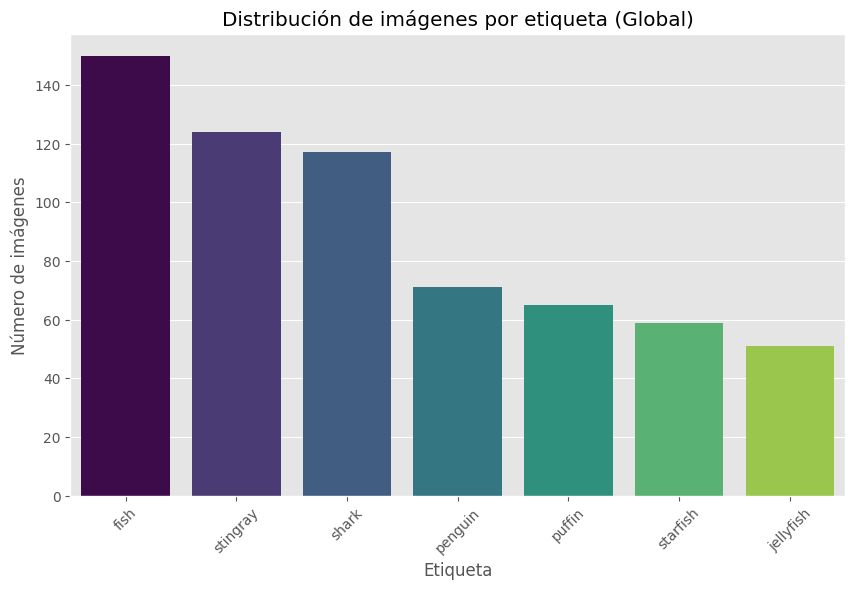

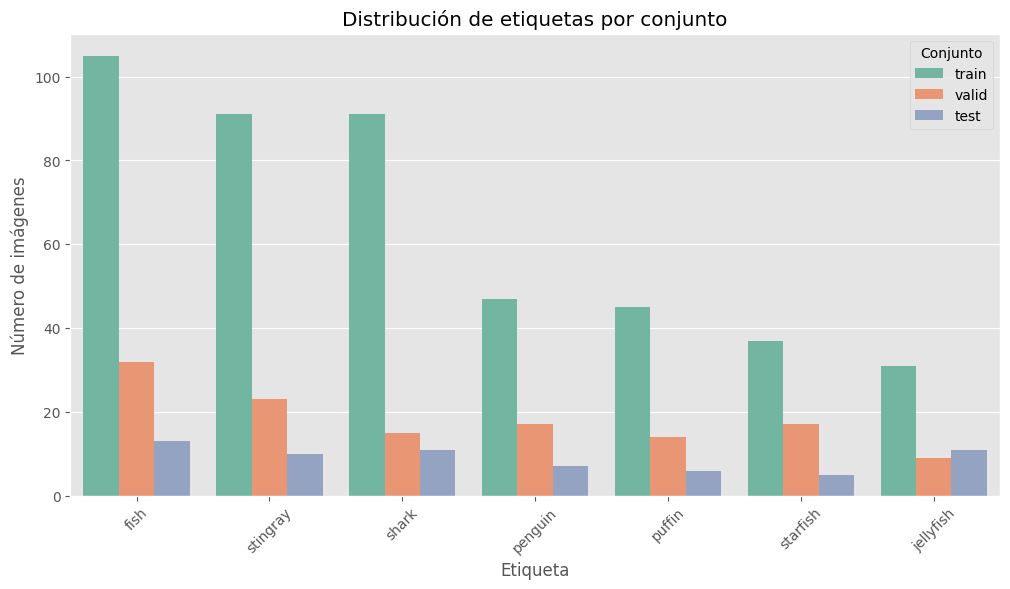


Proporción de cada etiqueta en cada conjunto:


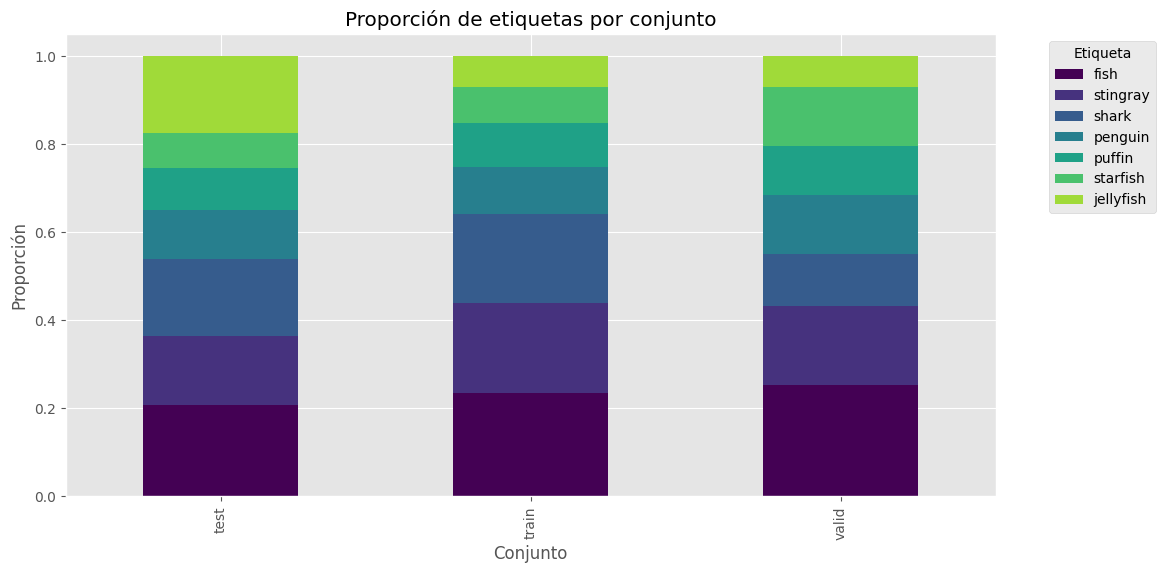

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Función para cargar las nuevas etiquetas por cada conjunto
def load_new_labels(data_dir, set_name):
    annotation_path = os.path.join(data_dir, set_name, "annotations.csv")
    filenames, labels = annotation_to_labels(annotation_path)
    df_labels = pd.DataFrame({"filename": filenames, "label": labels})
    df_labels["dataset"] = set_name
    return df_labels

# Cargar etiquetas de todos los conjuntos
df_new_labels = pd.concat([load_new_labels("data", set_name) for set_name in ["train", "valid", "test"]], ignore_index=True)

# Mostrar estadísticas básicas
print("═" * 50)
print("ESTADÍSTICAS BÁSICAS CON NUEVAS ETIQUETAS")
print("═" * 50)
print(f"Total de imágenes etiquetadas: {df_new_labels.shape[0]}")
print(f"Imágenes únicas: {df_new_labels['filename'].nunique()}")
print(f"Etiquetas generadas: {df_new_labels['label'].unique()}")

# Conteo y orden de etiquetas
labels_count = df_new_labels['label'].value_counts().sort_values(ascending=False)
print("\nConteo de imágenes por etiqueta (orden ascendente):")
print(labels_count)

# Generar colores consistentes para las etiquetas
ordered_classes = labels_count.index.tolist()
color_dict = {label: mcolors.to_hex(cm.viridis(i/len(ordered_classes))) for i, label in enumerate(ordered_classes)}

# Gráfico de distribución global
plt.figure(figsize=(10, 6))
sns.barplot(
    data=pd.DataFrame({'label': labels_count.index, 'count': labels_count.values}),
    x="label", y="count", hue="label", palette=color_dict, dodge=False, order=ordered_classes
)
plt.title("Distribución de imágenes por etiqueta (Global)")
plt.xlabel("Etiqueta")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.show()

# Distribución por conjunto
plt.figure(figsize=(12, 6))
sns.countplot(data=df_new_labels, x="label", hue="dataset", palette="Set2", order=ordered_classes)
plt.title("Distribución de etiquetas por conjunto")
plt.xlabel("Etiqueta")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.legend(title="Conjunto")
plt.show()

# Análisis de proporciones
df_prop = pd.merge(
    df_new_labels.groupby(["dataset", "label"]).size().reset_index(name="count"),
    df_new_labels.groupby("dataset").size().reset_index(name="total"),
    on="dataset"
)
df_prop["proporcion"] = df_prop["count"] / df_prop["total"]

print("\nProporción de cada etiqueta en cada conjunto:")
df_prop.pivot(index="dataset", columns="label", values="proporcion")[ordered_classes].plot(
    kind="bar", stacked=True,
    color=[color_dict[label] for label in ordered_classes],
    figsize=(12, 6)
)
plt.title("Proporción de etiquetas por conjunto")
plt.xlabel("Conjunto")
plt.ylabel("Proporción")
plt.legend(title="Etiqueta", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Con este output se puede ver que el desbalanceo que parecía haber antes de reetiquetar no es tan grande, por ejemplo, cuando una imagen se etiqueta como "fish" es porque hay muchos peces en la imagen, que contaban en la anterior evaluación.

Dicho esto, si que se observa un desbalance que puede ser o asumido o tratado. Hay que tener en cuenta que se cuenta con pocos datos entonces quizá sea interesante admitir un pequeño desbalanceo.

# Código anterior

In [9]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import shutil

# Directorios de datos originales
base_dir = "data"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

# Directorios para datos procesados
processed_base = "data/processed"
processed_train_dir = os.path.join(processed_base, "train")
processed_valid_dir = os.path.join(processed_base, "validation")

os.makedirs(processed_train_dir, exist_ok=True)
os.makedirs(processed_valid_dir, exist_ok=True)

# Mapeo de clases a identificadores
class_mapping = {
  "fish": 1,
  "jellyfish": 2,
  "penguin": 3,
  "shark": 4,
  "puffin": 5,
  "stingray": 6,
  "starfish": 7
}

def process_folder(input_folder, output_folder, ann_df):
  """
  Procesa las imágenes en 'input_folder' y guarda en 'output_folder':
    - Copia la imagen original.
    - Si la imagen contiene más de una clase, genera una imagen sintética donde se reemplazan
      los píxeles de la clase predominante por el color medio del resto de la imagen.
    - Se registra la información en new_dataset.csv:
        * Para la imagen original se utiliza la primera clase (más frecuente).
        * Para la imagen sintética se utiliza la segunda clase (si existe).
  """
  info = []  # Lista para almacenar la información que se registrará en el CSV

  # Se obtienen los archivos de imagen (.jpg, .jpeg, .png)
  image_files = [f for f in os.listdir(input_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

  for name in tqdm(image_files, desc=f"Procesando {os.path.basename(input_folder)}"):
    path = os.path.join(input_folder, name)
    image = Image.open(path).convert("RGB")
    w, h = image.size
    mask = np.zeros((h, w), dtype=np.uint8)

    # Asignar en la máscara el identificador de cada clase según las anotaciones
    for _, row in ann_df[ann_df["filename"] == name].iterrows():
      cid = class_mapping[row["class"]]
      mask[int(row["ymin"]):int(row["ymax"]), int(row["xmin"]):int(row["xmax"])] = cid

    # Se obtienen las clases presentes y se elimina el fondo (0)
    uniques, counts = np.unique(mask, return_counts=True)
    counts_dict = dict(zip(uniques, counts))
    counts_dict.pop(0, None)  # Se elimina el fondo

    # Se ordenan las clases por cantidad de píxeles (de mayor a menor)
    sorted_classes = sorted(counts_dict.items(), key=lambda x: x[1], reverse=True)

    # Verificar que sorted_classes no esté vacío antes de acceder a su primer elemento
    if not sorted_classes:
      print(f"No se encontraron anotaciones para la imagen: {name}")
      continue  # Salta al siguiente elemento

    prim_id, prim_area = sorted_classes[0]
    prim_label = next(label for label, idx in class_mapping.items() if idx == prim_id)

    # Registro para la imagen original
    info.append({"filename": name, "predominant_class": prim_label, "area": prim_area})
    shutil.copy(path, os.path.join(output_folder, name))

    # Solo se genera la imagen sintética si hay más de una clase anotada
    if len(sorted_classes) > 1:
      sec_id, sec_area = sorted_classes[1]
      sec_label = next(label for label, idx in class_mapping.items() if idx == sec_id)

      arr = np.array(image)
      mask_prim = (mask == prim_id)
      mean_color = arr[~mask_prim].mean(axis=0).astype(np.uint8)
      syn_arr = arr.copy()
      syn_arr[mask_prim] = mean_color

      base, _ = os.path.splitext(name)
      syn_name = f"{base}_synthetic.jpg"
      Image.fromarray(syn_arr).save(os.path.join(output_folder, syn_name))

      info.append({"filename": syn_name, "predominant_class": sec_label, "area": sec_area})

  pd.DataFrame(info).to_csv(os.path.join(output_folder, "new_dataset.csv"), index=False)
  print(f"Procesamiento completado en {os.path.basename(input_folder)}. CSV guardado.")

# Lectura de anotaciones para conjuntos de entrenamiento y validación
train_ann = pd.read_csv(os.path.join(train_dir, "annotations.csv"))
valid_ann = pd.read_csv(os.path.join(valid_dir, "annotations.csv"))

process_folder(train_dir, processed_train_dir, train_ann)
process_folder(valid_dir, processed_valid_dir, valid_ann)

print("Todos los conjuntos han sido procesados correctamente.")

FileNotFoundError: [Errno 2] No such file or directory: 'data/practica_1_dataset/train/annotations.csv'

In [ ]:
import tensorflow as tf
import pandas as pd
import os

# Ruta del archivo CSV
csv_path = r'data/processed/train/new_dataset.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"No se encontró el archivo CSV en: {csv_path}")

# Cargar el CSV usando pandas
df = pd.read_csv(csv_path)
rutas_archivos = df['filename'].tolist()
etiquetas = df['predominant_class'].tolist()

# Obtener el directorio donde se encuentra el CSV y construir la ruta completa de cada imagen
directorio_csv = os.path.dirname(os.path.abspath(csv_path))
print("Directorio CSV:", directorio_csv)
rutas_imagenes = [os.path.join(directorio_csv, nombre) for nombre in rutas_archivos]

# Función auxiliar que se ejecuta en modo eager a través de tf.py_function
def _cargar_imagen(ruta, etiqueta):
    # Convertir el tensor a un valor numpy y luego decodificarlo a str
    ruta_str = ruta.numpy().decode('utf-8')
    # print("Cargando la imagen desde:", ruta_str)

    # Leer y decodificar la imagen
    imagen_bytes = tf.io.read_file(ruta_str)
    imagen_decoded = tf.image.decode_image(imagen_bytes, channels=3, expand_animations=False)
    imagen_resized = tf.image.resize(imagen_decoded, [256, 256])

    return imagen_resized, etiqueta

# Función de mapeo que utiliza tf.py_function para ejecutar _cargar_imagen en modo eager
def cargar_imagen(ruta, etiqueta):
    imagen, etiqueta_out = tf.py_function(
        func=_cargar_imagen,
        inp=[ruta, etiqueta],
        Tout=[tf.float32, etiqueta.dtype]
    )
    # Definir la forma fija de la imagen resultante para el grafo
    imagen.set_shape([256, 256, 3])
    return imagen, etiqueta_out

# Crear el dataset a partir de la lista de rutas y etiquetas
dataset = tf.data.Dataset.from_tensor_slices((rutas_imagenes, etiquetas))
dataset = dataset.map(cargar_imagen, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(1)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

# Ejemplo de iterar sobre el dataset
for imagenes, labels in dataset.take(1):
    print("Batch de imágenes:", imagenes.shape)
    print("Batch de etiquetas:", labels)


In [ ]:
ds_iter = dataset.take(1).as_numpy_iterator()
for el in ds_iter:
    print("Imagen:", el[0].shape, "Etiqueta:", el[1])
    break  # Solo para mostrar un ejemplo

In [ ]:
!dir